# How to extract Data from a Drift device

As it was already [explained](../panda_drift.md), _PANDA|Drift_ keep a history of input data that might be images from CV cameras, sensor data or metrics.
In this tutorial we learn:

1. How to connect a Drift device and explore topics
2. Download and parse a Drift Package
3. Extract an image from a CV camera
4. Extract time series from an acceleration sensor
5. Get metrics

## Connect and explore topics

To connect to a device, you need to know its hostname or IP address and password:

In [6]:
import os
from drift_client import DriftClient

drift_client = DriftClient("drift-test-rig.local", os.getenv("DRIFT_PASSWORD"))

print(drift_client.get_topics())

['acc-0', 'acc-1', 'acc-2', 'acc-3', 'acc-4', 'acc-5', 'acc-6', 'acc-7', 'camera', 'energy-distr-0', 'energy-distr-1', 'energy-distr-2', 'energy-distr-3', 'energy-distr-4', 'energy-distr-5', 'energy-distr-6', 'energy-distr-7']


You can see that the Drift device has few topics. Unfortunately, the device doesn't provide information about the type, and you should know it in advance. Here we have 8 acceleration signals (time series), 8  energy distributions (metrics of accelerations) and one camera (images).

## Download and parse a Drift package
When you know a topic name you can load some bulk of packages for a time interval. Let's take packages of camera data for the last 5 seconds:

In [7]:
from datetime import datetime, timedelta

package_names = drift_client.get_package_names(
    "camera", datetime.utcnow() - timedelta(seconds=5), datetime.utcnow()
)
print(f"Found {len(package_names)} packages")
print(package_names)

Found 4 packages
['camera/1661872527806.dp', 'camera/1661872528807.dp', 'camera/1661872529807.dp', 'camera/1661872530807.dp']


We should take ~5 packages because we capture an image each second. Let's download one from our object storage and parse it:

In [8]:
pkg = drift_client.get_item(package_names[0])
print(f"Download package id={pkg.package_id} status={pkg.status_code}")

Download package id=1661872527806 status=0


All packages have at least an `ID` and `status code`. The package ID is unique for a topic, it is a timestamp when an event in the system happened. If you know that topic 'A' has metrics for data from topic 'B' they will have the same IDs, so that you can align data from different topics that belong to the same event. A package has the status code 0 if it has valid data.

Because we download a Drift package it always contains [WaveletBuffer](https://github.com/panda-official/WaveletBuffer). Let's take it and play a bit with:

In [9]:
buffer = pkg.as_buffer()
print(buffer)

WaveletBuffer<signal_number=3, signal_shape=(1920x1200), decomposition_steps=4, wavelet_type=WaveletType.DB3>


## Extract an image from a CV camera
From the previous step, we see that the buffer has some meta information about itself, and we can see that it has fullHD 3-channeled picture. We can extract it as a numpy array:

Scaled image (3, 300, 480)


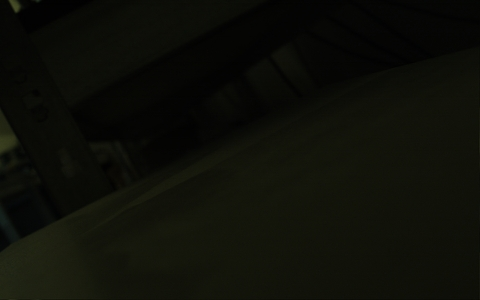

In [10]:
from wavelet_buffer.img import RgbJpeg, GrayJpeg
from IPython.display import Image

pic = buffer.compose(
    scale_factor=2
)  # we may use scale factor and restore smaller version of image

print(f"Scaled image {pic.shape}")

jpeg = RgbJpeg().encode(pic)
Image(data=jpeg)

## Extract time series from an acceleration sensor
Wavelet decomposition can be applied